In [1]:
!ls input

sample_submission.csv     test.json                 train.json
sample_submission.csv.zip test.json.zip             train.json.zip


In [183]:
import pandas as pd
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import split, explode, lit
from pyspark.mllib.classification import SVMWithSGD, SVMModel, LogisticRegressionWithLBFGS, NaiveBayes
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, DoubleType

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [3]:
sqlContext = SQLContext(sc)

In [4]:
def read_json(path):
    text = sc.wholeTextFiles(path).map(lambda x: x[1])
    return sqlContext.read.json(text)

In [48]:
train = read_json("input/train.json")
test = read_json("input/test.json")

In [26]:
train.printSchema()

root
 |-- cuisine: string (nullable = true)
 |-- id: long (nullable = true)
 |-- ingredients: array (nullable = true)
 |    |-- element: string (containsNull = true)



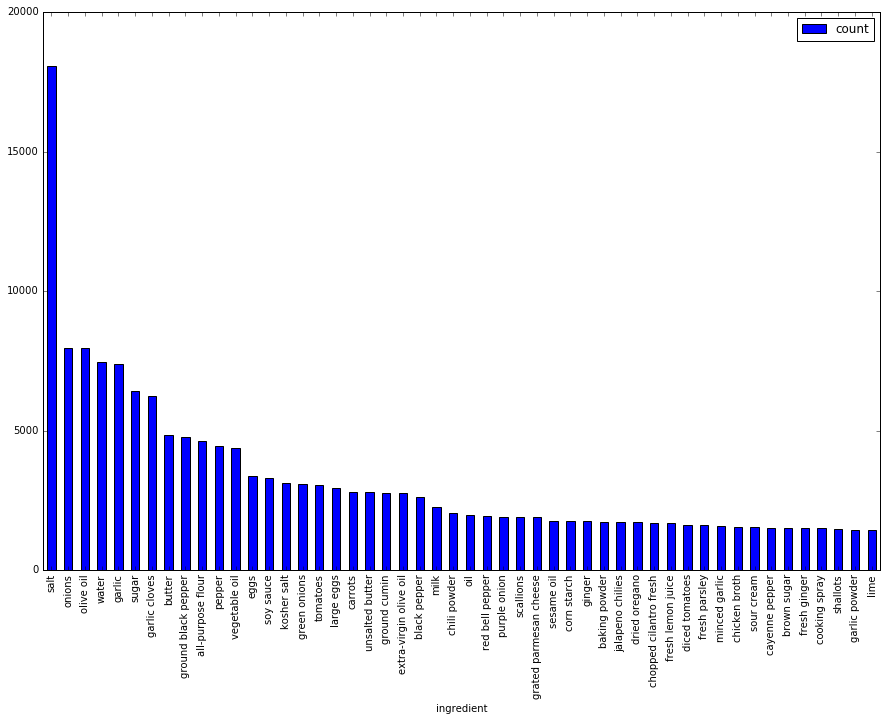

In [7]:
# explode the ingredients and store in "train_as_a_list"
train.select(
    train['id'],
    explode(train['ingredients']).alias('ingredient'),
    train['cuisine']
).registerTempTable("train_as_a_list")

# look at the most frequent ingredient
df = sqlContext.sql("""
SELECT ingredient, count(id) as count
from train_as_a_list
group by ingredient
order by count desc
limit 50
""")
df.toPandas().plot(kind='bar', x='ingredient')

In [194]:
cv = CountVectorizer(inputCol="ingredients", outputCol="ingredients_vector")
si = StringIndexer(inputCol="cuisine", outputCol="cuisineIndex")
prepPipeline = Pipeline(stages=[cv, si])

def train_and_predict(train, test):
    
    
    prep = prepPipeline.fit(train)
    train_prepared = prep.transform(train)
    test_prepared = prep.transform(test)
    
    to_train = train_prepared.rdd.map(lambda row: LabeledPoint(row['cuisineIndex'], row['ingredients_vector']))
    
    model = NaiveBayes.train(to_train)

    predict = udf(lambda ingredients_vector: float(model.predict(ingredients_vector)), DoubleType())
    preds = test_prepared.withColumn("cuisineIndexPrediction", predict(test_prepared.ingredients_vector))
    
    cuisineLabels = pipe2.stages[1].labels
    converter = IndexToString(inputCol="cuisineIndexPrediction", outputCol="cuisinePrediction", labels=cuisineLabels)
    predictions = converter.transform(preds)
    
    return predictions


In [191]:
# some cross validation of model
(trainingData, testData) = train.randomSplit([0.7, 0.3])

predictions = train_and_predict(trainingData, testData)

evaluator = MulticlassClassificationEvaluator(
    labelCol="cuisineIndex", predictionCol="cuisineIndexPrediction", metricName="precision")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % accuracy)

Accuracy = 0.735146 


In [193]:
# do the actual prediction
predicitons = train_and_predict(train, test)

submission = predicitons.select(predicitons['id'], predicitons['cuisinePrediction'].alias('cuisine'))
submission.toPandas().to_csv('output/submission.csv')